# GEODOS data processing

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
import glob
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


## Read Logfile

In [2]:
dto = '/storage/stations/Polednik/geodos/2021/10/10'
#dto = '/storage/stations/Polednik/geodos/2021/10/13'
#dto = '/storage/stations/Polednik/geodos/2021/10/EC'

fto = dto + '/DATALOG.TXT'

l=[]
l.extend(range(0,300))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )

df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)

sn = df.loc[df[0]=='$AIRDOS',3]
fw = df.loc[df[0]=='$AIRDOS',2]
last = df.loc[df[0]=='$AIRDOS'].index
print ('s.n.: ',sn[0])
print ('f.v.: ',fw[0])
print(df.loc[df[0]=='$AIRDOS',1])
print(len(df))
print(last[-1:][0])

# keep only last run
#df.drop(df.index[:last[-1:][0]], inplace=True) 

s.n.:  1290c00806a20091e412a000a0000010
f.v.:  51832f3
0         GEO2
68310     GEO2
68311     GEO2
68312     GEO2
68313     GEO2
          ... 
209368    GEO2
209369    GEO2
209370    GEO2
209371    GEO2
209372    GEO2
Name: 1, Length: 141064, dtype: object
207379
209372


## Fill position and time (Galileo)

In [3]:
#df.drop(df.loc[(df[0]=='$GNRMC') & (df[2]=='V')].index, inplace=True)
df.loc[(df[0]=='$GNRMC'),'flag']=True
df.loc[(df[0]=='$HIST'),'flag']=False
df.flag = df.flag.fillna(method='ffill')
df['latf'] = pd.to_numeric(df.loc[df[0]=='$GNRMC',3])
df['lonf'] = pd.to_numeric(df.loc[df[0]=='$GNRMC',5])
#df.loc[(df[0]=='$TIME') & (df['flag']),'on_miliseconds'] = pd.to_numeric(df.loc[df[0]=='$TIME',1]) * 1000
#df['on_miliseconds'] = pd.to_numeric(df.loc[df[0]=='$TIME',1]) * 1000
df['on_miliseconds'] = pd.to_numeric(df.loc[(df[0]=='$TIME') & (df['flag']),1]) * 1000
df['miliseconds'] = pd.to_numeric(df.loc[df[0]=='$HIST',2]) * 1000
df['gps_time'] = df.loc[df[0]=='$GNRMC',1]
df['gps_date'] = df.loc[df[0]=='$GNRMC',9]
df['alt'] = df.loc[df[0]=='$GNGGA',9]
df.loc[(df[0]=='$GNRMC') & (df[6]=='E'),'lon_hem']=1
df.loc[(df[0]=='$GNRMC') & (df[6]=='W'),'lon_hem']=-1
df.loc[(df[0]=='$GNRMC') & (df[4]=='N'),'lat_hem']=1
df.loc[(df[0]=='$GNRMC') & (df[4]=='S'),'lat_hem']=-1
df['lat'] = (np.trunc(df['latf']/100) + (((df['latf']/100) - np.trunc(df['latf']/100)) * 100) / 60.0) * df['lat_hem']
df['lon'] = (np.trunc(df['lonf']/100) + ((df['lonf']/100) - np.trunc(df['lonf']/100)) * 100 / 60.0) * df['lon_hem']  
df['date'] = pd.to_datetime(df['gps_date']+df['gps_time'], format='%d%m%y%H%M%S.%f')#,errors='coerce')
df.drop('lon_hem', axis=1, inplace=True)
df.drop('lat_hem', axis=1, inplace=True)
df.drop('latf', axis=1, inplace=True)
df.drop('lonf', axis=1, inplace=True)
df.drop('gps_time', axis=1, inplace=True)
df.drop('gps_date', axis=1, inplace=True)
df['meas'] = df.index
#df['meas'] = df.loc[df[0]=='$HIST',1]
df.loc[df[0]=='$HITS','meas'] = np.nan
df = df.fillna(method='ffill')
df.meas = df.meas.astype(int)
df.drop(df[df[0]=='$GPGGA'].index, inplace=True)
df.drop(df[df[0]=='$GNRMC'].index, inplace=True)
df.drop(df[df[0]=='$AIRDOS'].index, inplace=True)
df.drop(df[df[0]=='$TIME'].index, inplace=True)
df['UTC'] = df['date'] + pd.to_timedelta(df['miliseconds'], unit='ms') - pd.to_timedelta(df['on_miliseconds'], unit='ms')
#df.drop('date', axis=1, inplace=True)
#df.drop('miliseconds', axis=1, inplace=True)
#df.drop('on_miliseconds', axis=1, inplace=True)
df

,0,1,2,3,4,5,6,7,8,9,...,299,flag,on_miliseconds,miliseconds,alt,lat,lon,date,meas,UTC
1,$GNVTG,GEO2,T,1290c00806a20091e412a000a0000010,M,0.377,N,0.697,K,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1,NaT
2,$GNGGA,143208.00,4903.84979,N,01323.70453,E,1,09,1.01,1351.1,...,NaN,NaN,NaN,NaN,1351.1,NaN,NaN,NaT,2,NaT
3,$GNGSA,A,3,03,04,22,01,17,19,09,...,NaN,NaN,NaN,NaN,1351.1,NaN,NaN,NaT,3,NaT
4,$GNGSA,A,3,03,04,22,01,17,19,09,...,NaN,NaN,NaN,NaN,1351.1,NaN,NaN,NaT,4,NaT
9,$GLGSV,2,1,06,68,26,053,17,70,31,...,NaN,NaN,NaN,NaN,1351.1,NaN,NaN,NaT,9,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68305,$HITS,4,101776,56,118812,9,210650,10,229111,16,...,NaN,False,501129240.0,502052810.0,1351.4,49.064121,13.395117,2021-08-18 09:44:17,68304,2021-08-18 09:59:40.570
68306,$HIST,30808,502068.73,86634.75,6.50,-0.26,-257,-257,-257,55524,...,NaN,False,501129240.0,502068730.0,1351.4,49.064121,13.395117,2021-08-18 09:44:17,68306,2021-08-18 09:59:56.490
68307,$HITS,3,209350,10,258456,27,261942,13,-257,55524,...,NaN,False,501129240.0,502068730.0,1351.4,49.064121,13.395117,2021-08-18 09:44:17,68306,2021-08-18 09:59:56.490
68308,$HIST,30809,502084.67,86647.50,6.50,-0.26,-257,-257,-257,54655,...,NaN,False,501129240.0,502084670.0,1351.4,49.064121,13.395117,2021-08-18 09:44:17,68308,2021-08-18 10:00:12.430


## Add individual events to histogram

In [4]:
df.dropna(subset=['UTC'], inplace=True)
hist = df.loc[df[0]=='$HIST'].iloc[:,:20].copy()
hist.iloc[:,1:] = hist.iloc[:,1:].apply(pd.to_numeric) #,errors='coerce')
#hist[0] = df[0]
hist['alt'] = df['alt'].apply(pd.to_numeric,errors='coerce')
hist['lat'] = df['lat'].apply(pd.to_numeric,errors='coerce')
hist['lon'] = df['lon'].apply(pd.to_numeric,errors='coerce')
hist['meas'] = df['meas'].apply(pd.to_numeric,errors='coerce')
hist['UTC'] = df['UTC']
#hist.iloc[:,18:269] = 0
hist.set_index('meas', inplace=True)

hits = df.loc[df[0]=='$HITS'].copy()
#hits['meas'] = hist.index
hits.iloc[:,1:] = hits.iloc[:,1:].apply(pd.to_numeric)
hits['UTC'] = df['UTC']
hits.set_index('meas', inplace=True)


In [5]:
hits.iloc[:,40:300] = 0
for i in range(len(hits)):
    for j in range(hits.iloc[i,1]):
        hits.iloc[i,int(40+hits.iloc[i,j*2+3])] +=1
#hits.merge(hist)
#hits.drop(hits.iloc[:,18:40], axis=1, inplace=True)
histogram = pd.DataFrame()
histogram = hist.iloc[:,11:18]
histogram = histogram.join(hits.iloc[:,40+11:])
histogram['temperature'] = hist[4]
histogram['pressure'] = hist[3]
histogram['voltage'] = hist[5]
histogram['current'] = hist[6]
histogram = histogram.rename(columns={x:y for x,y in zip(histogram.columns[:258],range(0,258))})
histogram

,0,1,2,3,4,5,6,7,8,9,...,miliseconds,alt,lat,lon,date,UTC,temperature,pressure,voltage,current
meas,,,,,,,,,,,,,,,,,,,,,
14,2.0,2,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,26810.0,1351.1,49.064136,13.395068,1.628779e+18,2021-08-12 14:32:25.080,23.13,87376.50,4.16,-22
16,5.0,2,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,...,42970.0,1351.1,49.064136,13.395068,1.628779e+18,2021-08-12 14:32:41.240,23.25,87360.25,4.16,-17
18,3.0,2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,59130.0,1351.1,49.064136,13.395068,1.628779e+18,2021-08-12 14:32:57.400,23.38,87357.00,4.16,-15
20,1.0,3,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,75300.0,1351.1,49.064136,13.395068,1.628779e+18,2021-08-12 14:33:13.570,23.56,87357.25,4.16,-15
22,2.0,0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,91160.0,1351.1,49.064136,13.395068,1.628779e+18,2021-08-12 14:33:29.430,23.63,87356.50,4.16,-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68300,2.0,0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,502020960.0,1351.4,49.064121,13.395117,1.629280e+18,2021-08-18 09:59:08.720,6.44,86654.00,-0.26,-257
68302,4.0,3,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,502036880.0,1351.4,49.064121,13.395117,1.629280e+18,2021-08-18 09:59:24.640,6.44,86639.50,-0.26,-257
68304,4.0,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,502052810.0,1351.4,49.064121,13.395117,1.629280e+18,2021-08-18 09:59:40.570,6.44,86625.75,-0.26,-257


## Plot Flux

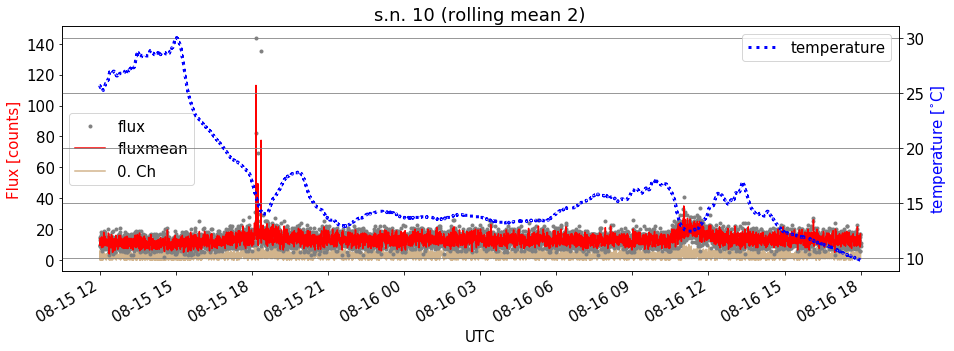

In [6]:
NOISE_LEVEL = 0
LAST_CHANNEL = 256
WINDOW = 2

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2021-08-15 17:45:00':'2021-08-15 18:40:00']
xx = xx.loc['2021-08-15 12:00:00':'2021-08-16 18:00:00']

#plt.yscale('log')
xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

xx['flux'].plot(c='gray', linestyle='', marker='.')
xx['fluxmean'].plot(c='red')
(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title("s.n. " + s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts]', color='red')
plt.legend(loc=6)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='blue', label='temperature', linewidth='3', linestyle=':', drawstyle='steps-mid')
plt.ylabel(r'temperature [$^{\circ}$C]', color='blue')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



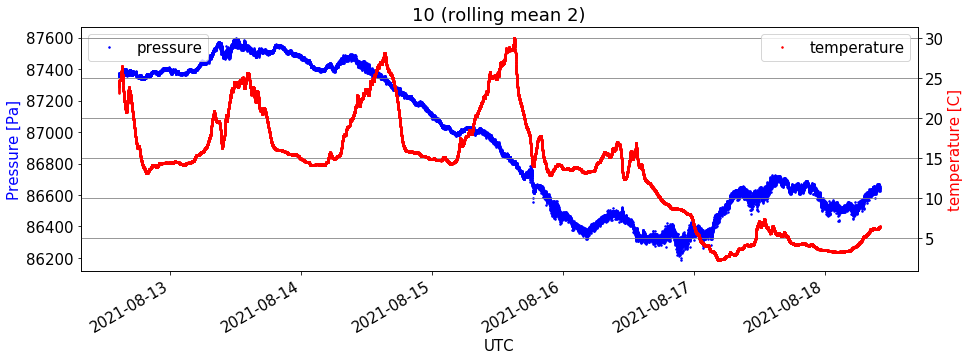

In [7]:
plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']



xx['pressure'].plot(c='blue', linestyle='', marker='.', ms=3, label = 'pressure')

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Pressure [Pa]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='red', label='temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('temperature [C]', color='red')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



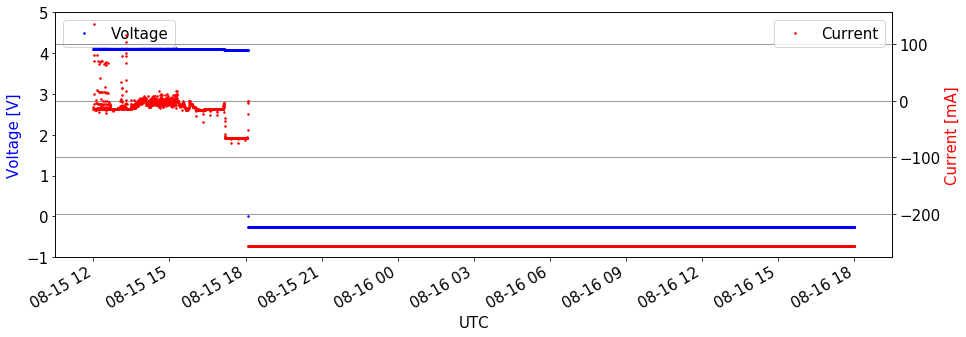

In [8]:
plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']
#xx = xx.loc['2021-08-15 00:00:00':'2021-08-16 00:00:00']
xx = xx.loc['2021-08-15 12:00:00':'2021-08-16 18:00:00']



xx['voltage'].plot(c='blue', linestyle='', marker='.', ms=3, label = 'Voltage')

s = fto.split('/')
#plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
plt.ylim([-1,5])
plt.xlabel('UTC')
plt.ylabel(r'Voltage [V]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['current'].plot(c='red', label='Current', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('Current [mA]', color='red')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



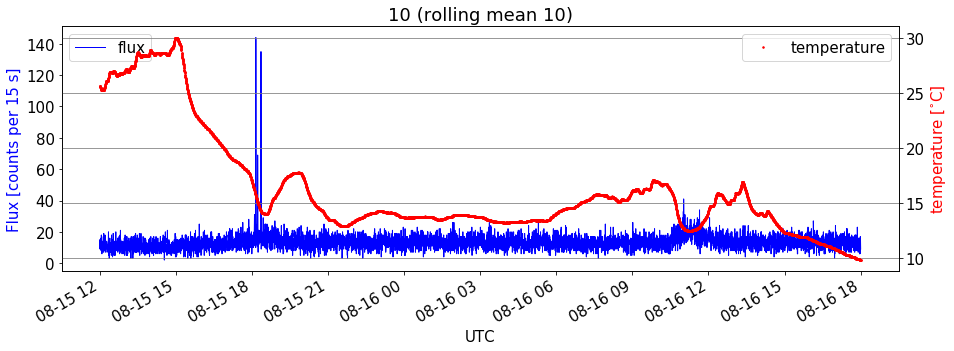

In [9]:
NOISE_LEVEL = 0
LAST_CHANNEL = 240
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']
xx = xx.loc['2021-08-15 12:00:00':'2021-08-16 18:00:00']

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

#xx['flux'].plot(c='gray', marker='.', linewidth=1)
xx['flux'].plot(c='blue', linewidth=1)
#xx['fluxmean'].plot(c='red')
#(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts per 15 s]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='red', label='temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel(r'temperature [$^{\circ}$C]', color='red')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



# Blitzortung

In [19]:
lat=49.0640992 # Polednik
lon=13.3950208

start=pd.Timestamp('2021-08-15 12:00')
end=pd.Timestamp('2021-08-16 18:00')

BLITZ_DIST = 60

print(start, end, lat, lon)
region=1

### url for json data preparation
url=[]

for i in range(0,int(np.ceil((end-start).total_seconds()/600)+1)):
    next=start+ pd.Timedelta(minutes=i*10)
    url.append('http://data.blitzortung.org/Data/Restricted/Strikes_%01d/%02d/%02d/%02d/%02d/%02d.json' % (region, next.year, next.month, next.day, next.hour, np.floor((next.minute)//10)*10))

import requests
blitz=pd.DataFrame()
for i in range(len(url)):
    try:
        html = requests.get(url[i]).content
        blitz_part = pd.read_json(html,lines=True)
        #blitz_part.drop(columns=['status','sig'], inplace=True)#,'region', 
        blitz=blitz.append(blitz_part)
    except:
        print("No data", url[i])
        pass
blitz.set_index(['time'], inplace=True)

### reduction of too distant events
blitz=blitz[(blitz['lat']>(lat-2) )&(blitz['lat']<(lat+2) )]
blitz=blitz[(blitz['lon']>(lon-3.5) )&(blitz['lon']<(lon+3.5) )]

### calculation of distance of events from station
#from math import radians, cos, sin, asin, sqrt, atan2, degrees
try:
    blitz.drop(columns=['alt','pol','region'], inplace=True)
except:
    print('No columns to drop (alt, pol, region)')
    pass
#blitz['time']=blitz.index    
blitz['date'] = pd.to_datetime(blitz.index, unit='ns')
blitz.reset_index(inplace=True)
blitz.set_index('date', inplace=True)

blitz['lonRad']=np.radians(blitz.lon)
blitz['latRad']=np.radians(blitz.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
blitz['DlonRad']=lonRad-blitz.lonRad
blitz['DlatRad']=latRad-blitz.latRad
blitz['a']=np.sin(blitz.DlatRad/2.)**2. + np.cos(blitz.latRad) * np.cos(latRad) * np.sin(blitz.DlonRad/2.)**2.
blitz['km'] = 2. * np.arcsin(np.sqrt(blitz.a))*6378.
blitz.drop(columns=['lonRad','latRad','DlonRad','DlatRad','a'], inplace=True)
try:
    blitz.drop(columns=['alt','pol','region'], inplace=True)
except:
    print('No columns to drop (alt, pol, region)')
blitz = blitz.loc[blitz['km'] < BLITZ_DIST]
blitz['date'] = pd.to_datetime(blitz.index, unit='ns')
#blitz.reset_index(inplace=True)
#blitz.set_index('date', inplace=True)

blitz.to_csv(dto + "/blitz.csv")

print('end')

2021-08-15 12:00:00 2021-08-16 18:00:00 49.0640992 13.3950208
No columns to drop (alt, pol, region)
end


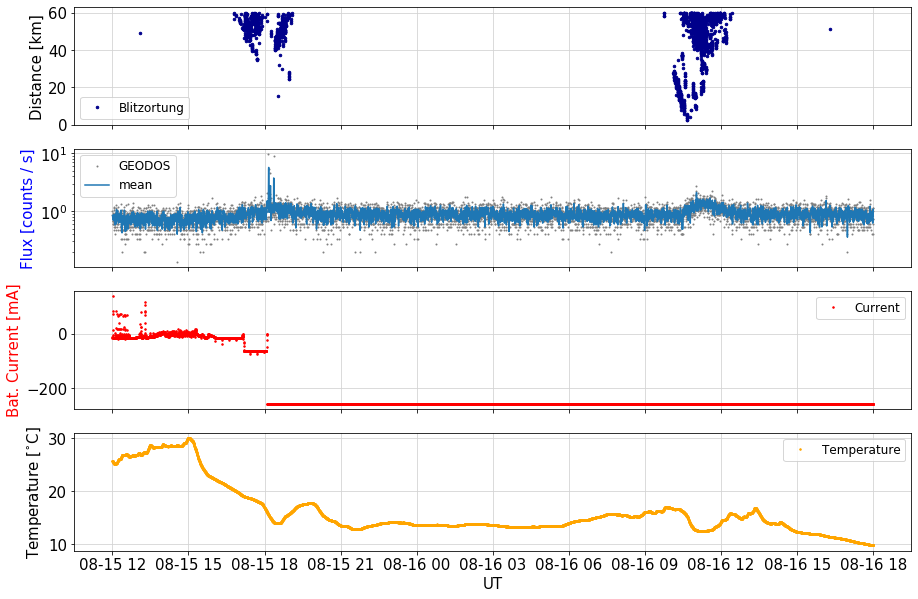

In [10]:
WINDOW = 3

blitz = pd.read_csv(dto + "/blitz.csv")
blitz['date'] = pd.to_datetime(blitz['date'])
blitz.set_index('date', inplace=True)

fig, (ax6, ax3, ax5, ax4) = plt.subplots(nrows=4, sharex=True, figsize=(15,10))
matplotlib.rcParams.update({'font.size': 12})

xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
xx = xx.loc['2021-08-15 12:00:00':'2021-08-16 18:00:00']
#xx = xx.loc['2021-08-15 18:00:00':'2021-08-16 18:15:00']

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))
xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

ax3.plot(xx['flux']/15, marker='.', color='gray', label='GEODOS', ms=2, linestyle='none')
ax3.plot(xx['fluxmean']/15, label='mean')
ax3.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax3.set_ylabel(r'Flux [counts / s]', color='blue')
ax3.set_yscale('log')
#ax3.set_ylim(2,300)
ax3.legend()


ax4.plot(xx['temperature'], c='orange', label='Temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
ax4.set_xlabel('UT')
ax4.set_ylabel(r'Temperature [$^{\circ}$C]')
ax4.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax4.legend()

ax6.plot(blitz.index, blitz.km, ls='', marker='.', ms=5, label='Blitzortung', c='darkblue')
ax6.set_ylabel('Distance [km]')
ax6.legend()
ax6.grid(b=True, which='major', color='lightgrey', linestyle='-')

ax5.plot(xx['current'], c='red', label='Current', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
ax5.set_ylabel('Bat. Current [mA]', color='red')
ax5.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax5.legend()


# Energy Spectrum

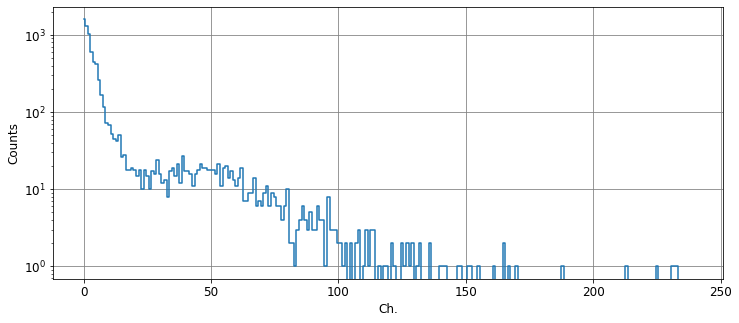

In [11]:
yy = histogram.copy()
yy.set_index('UTC', inplace = True, drop=False)
#yy = yy.loc['2021-08-15 11:00:00':'2021-08-16 18:00:00']
yy = yy.loc['2021-08-16 10:00:00':'2021-08-16 12:00:00']
yy = yy.rename(columns={x:y for x,y in zip(yy.columns[:258],range(0,258))})
ener = yy.iloc[:,0:240].sum()
ener = ener.reset_index()
plt.figure(figsize=(12,5))
plt.plot(ener[0], drawstyle='steps-mid')
plt.yscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(color='grey')
#plt.xlim([10,100])

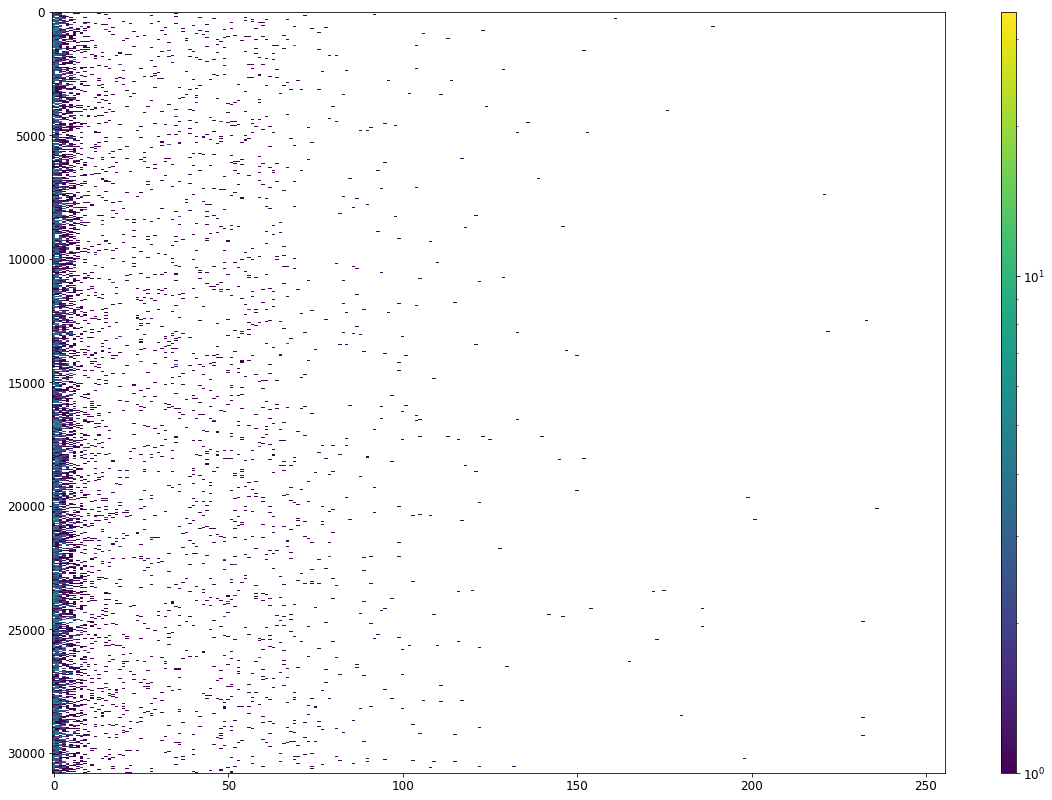

In [12]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(20, 14))
plt.imshow((histogram.iloc[:,0:256]), aspect='auto', norm=LogNorm())
plt.colorbar(aspect=50)
None